# Variables categóricas

Por último analizaremos el impacto de incluir variables categóricas en nuestros modelos.

Esta es una pregunta bastante común en problemas de modelado. ¿Qué tanto cambia el resultado a través de diferentes categorías?
Las categorías son variables discretas sin un orden específico. Por ejemplo:

- Sexo: masculino, femenino.
- Continente: América, Asia, África.
- Universidad: ITESO, Tecnológico de Monterrey, UDG.

Hay que tener cuidado, ya que en muchos contextos, este tipo de variables se codifican como variables numéricas (one-hot encoding, label encoding, entre otros) y se suelen tratar en los modelos como variables continuas, lo cual puede llevar a conclusiones incorrectas.

> **Objetivos:**
> - Incluir variables categóricas en nuestros análisis.

> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

## 1. Variables binarias

Comenzamos analizando el caso en que la variable categórica presenta dos posibilidades; como masculino y femenino. Usemos los datos de altura de la población !Kung San, usados en el tema pasado.

In [1]:
# Importar pandas
import pandas as pd

In [2]:
# Leer datos Howell1
height_data = pd.read_csv(
    "data/Howell1.csv",
    sep=";"
)

In [3]:
# Método describe
height_data.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


La variable `male` en nuestro conjunto de datos es una variable indicadora (o dummy). Aunque numéricas, las variables indicadoras no tienen el significado de que "uno (1) es más que cero (0)", y solo indican la presencia de cierta característica.

Hay varias maneras de usar este tipo de variables en un modelo. Una de ellas es incluir el indicador como una característica lineal:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta_m m_i \\
\alpha & \sim & \text{Normal}(178, 20) \\
\beta_m & \sim & \text{Normal}(0, 10) \\
\sigma & \sim & \text{Uniform}(0, 50) \\
\end{array}
\end{align}
$$

donde $h$ representa la altura y $m$ la variable dummy indicando que el individuo es masculino. Notemos que en este caso $\beta_m$ es la **diferencia esperada** entre hombres y mujeres:

- Cuando $m_i=1$, entonces $\mu_i=\alpha+\beta_m$.
- Cuando $m_i=0$, entonces $\mu_i=\alpha$

Esto puede ser complejo, dado que si no tenemos una idea de la diferencia en tamaño, ¿Cómo asignamos la previa?

Otra complicación de este enfoque es que se supone que hay más incertidumbre en la altura de los hombres que de las mujeres, lo cual puede o no ser cierto.

Otro enfoque disponible es usar una variable índice, la cual contiene enteros que corresponden a las diferentes categorías.

Con esto:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha_{SEX[i]} \\
\alpha_j & \sim & \text{Normal}(178, 20) \quad \text{for } j=0,1 \\
\sigma & \sim & \text{Uniform}(0, 50) \\
\end{array}
\end{align}
$$

In [4]:
# Importar pymc y arviz
import pymc as pm
import arviz as az

/home/esteban/anaconda3/envs/stat-rethink2-pymc_v4/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# Modelo para hombres y mujeres - mu tiene shape = 2
with pm.Model() as cat_model:
    sigma = pm.Uniform("sigma", 0, 50)
    alpha = pm.Normal("alpha", 178, 20, shape=2)
    mu = pm.Deterministic("mu", alpha)

    height = pm.Normal(
        "height",
        mu[height_data["male"]],
        sigma,
        observed=height_data["height"]
    )

    idata_cat = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [7]:
# Summary
az.summary(
    idata_cat,
    var_names=["mu", "sigma"],
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
mu[0],134.878,1.600,132.434,137.549
mu[1],142.589,1.717,139.803,145.235
sigma,27.428,0.832,26.125,28.771


Para evaluar la diferencia, podríamos extraer las muestras de `mu[0]` y `mu[1]` para restarlas. Sin embargo, en `pymc` resulta más fácil definir una variable determista con la diferencia.

In [8]:
# Modelo con diferencia (hace sentido usar pm.Deterministic)
with pm.Model() as cat_model:
    sigma = pm.Uniform("sigma", 0, 50)
    alpha = pm.Normal("alpha", 178, 20, shape=2)
    mu = pm.Deterministic("mu", alpha)

    height = pm.Normal(
        "height",
        mu[height_data["male"]],
        sigma,
        observed=height_data["height"]
    )
    diff = pm.Deterministic("diff", mu[0] - mu[1])
    idata_cat = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [9]:
# Summary
az.summary(
    idata_cat,
    var_names=["mu", "sigma", "diff"],
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
mu[0],134.932,1.602,132.435,137.551
mu[1],142.607,1.709,140.012,145.439
sigma,27.439,0.840,26.043,28.738
diff,-7.675,2.348,-11.484,-3.971


Con esto podemos observar la diferencia esperada en altura entre una mujer y un hombre de la población !Kung San.

## 2. Múltiples categorías

Con el enfoque anterior, lo podemos extender al caso de múltiples categorías. 

Retomemos el ejemplo del contenido energético de la leche:

In [10]:
# Leer Milk data
milk_data = pd.read_csv(
    "data/milk.csv",
    sep=";"
)

In [11]:
milk_data.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [12]:
milk_data["clade"].unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

Generemos una variable índice para el *clado*.

> Un clado es una agrupación que contiene un antepasado común y todos los descendientes (vivos y extintos) de ese antepasado.

In [13]:
# Clades to int dict
clade_to_int = dict(zip(
    milk_data["clade"].unique(),
    range(milk_data["clade"].nunique())
))
clade_to_int

{'Strepsirrhine': 0, 'New World Monkey': 1, 'Old World Monkey': 2, 'Ape': 3}

In [14]:
# Map clade -> clade_id
milk_data["clade_id"] = milk_data["clade"].map(clade_to_int)
milk_data.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,clade_id
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,0
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,0
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,0
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,0


In [15]:
# Standardize function
def standardize(y: pd.Series) -> pd.Series:
    return (y - y.mean()) / y.std()

In [16]:
# Estandarizamos la energía
milk_data["energy_std"] = standardize(milk_data["kcal.per.g"])
milk_data.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,clade_id,energy_std
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0,-0.940041
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,0,-0.816126
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,0,-1.125913
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,0,-1.001998
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,0,-0.258511


Ahora, el modelo:

$$
\begin{align}
\begin{array}{lcl}
K_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha_{CLADE[i]} \\
\alpha_j & \sim & \text{Normal}(0, 0.5) \quad \text{for } j=0,1,2,3 \\
\sigma & \sim & \text{Exponential}(1) \\
\end{array}
\end{align}
$$

In [17]:
# Modelo (alpha tiene shape = 4)
with pm.Model() as energy_model:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 0, 0.5, shape=4)
    mu = pm.Deterministic("mu", alpha)
    energy = pm.Normal(
        "energy",
        mu[milk_data["clade_id"]],
        sigma,
        observed=milk_data["energy_std"]
    )

    idata_energy = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

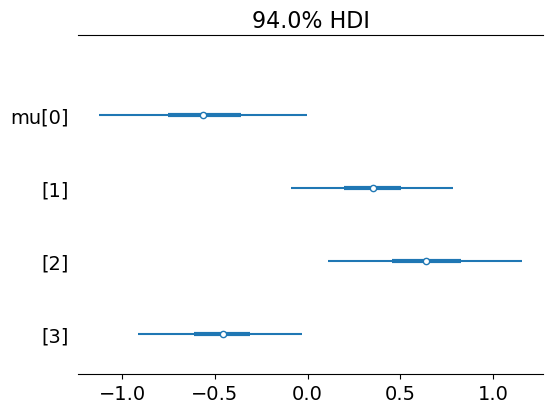

In [18]:
# Plot forest
az.plot_forest(
    idata_energy,
    var_names=["mu"],
    combined=True
)

In [19]:
clade_to_int

{'Strepsirrhine': 0, 'New World Monkey': 1, 'Old World Monkey': 2, 'Ape': 3}

# Anuncios parroquiales

## 1. Quiz del tema 9 el jueves 2 de octubre.
## 2. Tarea 5 del tema 9 queda pendiente (el jueves 2 de octubre la discutimos).